In [1]:
# VGG16
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape)
    inputs_gaf = Input(shape=input_shape)
    inputs_mtf = Input(shape=input_shape)
    
    base_rp = VGG16(include_top=False, input_tensor=inputs_rp)
    base_gaf = VGG16(include_top=False, input_tensor=inputs_gaf)
    base_mtf = VGG16(include_top=False, input_tensor=inputs_mtf)
    
    x_rp = Flatten()(base_rp.output)
    x_gaf = Flatten()(base_gaf.output)
    x_mtf = Flatten()(base_mtf.output)
    
    merged = Concatenate()([x_rp, x_gaf, x_mtf])
    
    x = Dense(512, activation='relu')(merged)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (201, 201, 4)
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.h5'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))
    
    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


2024-07-01 15:59:10.703357: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 15:59:10.714615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 15:59:10.730636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 15:59:10.730658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 15:59:10.740830: I tensorflow/core/platform/cpu_feature_gua

ValueError: The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(3, 3, 4, 64), Received: value.shape=(3, 3, 3, 64). Target variable: <KerasVariable shape=(3, 3, 4, 64), dtype=float32, path=block1_conv1/kernel>

In [2]:
#pleasee this time workkkkkkkkk
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Remove the alpha channel to make the images 3-channel (RGB)
def remove_alpha_channel(images):
    return images[:, :, :, :3]

X_rp_train = remove_alpha_channel(X_rp_train)
X_gaf_train = remove_alpha_channel(X_gaf_train)
X_mtf_train = remove_alpha_channel(X_mtf_train)

X_rp_val = remove_alpha_channel(X_rp_val)
X_gaf_val = remove_alpha_channel(X_gaf_val)
X_mtf_val = remove_alpha_channel(X_mtf_val)

X_rp_test = remove_alpha_channel(X_rp_test)
X_gaf_test = remove_alpha_channel(X_gaf_test)
X_mtf_test = remove_alpha_channel(X_mtf_test)

# Define a function to build the VGG16 model with unique layer names
def build_vgg16_model(input_shape, num_classes):
    def get_vgg16_with_custom_names(input_tensor, suffix):
        base_model = VGG16(include_top=False, input_tensor=input_tensor)
        for layer in base_model.layers:
            layer._name = f"{layer.name}_{suffix}"
        return base_model
    
    inputs_rp = Input(shape=input_shape, name='rp_input')
    inputs_gaf = Input(shape=input_shape, name='gaf_input')
    inputs_mtf = Input(shape=input_shape, name='mtf_input')
    
    base_rp = get_vgg16_with_custom_names(inputs_rp, 'rp')
    base_gaf = get_vgg16_with_custom_names(inputs_gaf, 'gaf')
    base_mtf = get_vgg16_with_custom_names(inputs_mtf, 'mtf')
    
    x_rp = Flatten(name='flatten_rp')(base_rp.output)
    x_gaf = Flatten(name='flatten_gaf')(base_gaf.output)
    x_mtf = Flatten(name='flatten_mtf')(base_mtf.output)
    
    merged = Concatenate(name='merged')([x_rp, x_gaf, x_mtf])
    
    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (201, 201, 3)  # 3-channel input
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.h5'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))
    
    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


ValueError: The name "block1_conv1" is used 3 times in the model. All operation names should be unique.

In [3]:
#noooo please this timeeeeee
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Remove the alpha channel to make the images 3-channel (RGB)
def remove_alpha_channel(images):
    return images[:, :, :, :3]

X_rp_train = remove_alpha_channel(X_rp_train)
X_gaf_train = remove_alpha_channel(X_gaf_train)
X_mtf_train = remove_alpha_channel(X_mtf_train)

X_rp_val = remove_alpha_channel(X_rp_val)
X_gaf_val = remove_alpha_channel(X_gaf_val)
X_mtf_val = remove_alpha_channel(X_mtf_val)

X_rp_test = remove_alpha_channel(X_rp_test)
X_gaf_test = remove_alpha_channel(X_gaf_test)
X_mtf_test = remove_alpha_channel(X_mtf_test)

# Define a function to build the VGG16 model with unique layer names
def build_vgg16_model(input_shape, num_classes):
    def get_vgg16_with_custom_names(input_tensor, suffix):
        with tf.keras.utils.custom_object_scope({'VGG16': VGG16}):
            base_model = VGG16(include_top=False, input_tensor=input_tensor)
            for layer in base_model.layers:
                layer._name = f"{layer.name}_{suffix}"
        return base_model
    
    inputs_rp = Input(shape=input_shape, name='rp_input')
    inputs_gaf = Input(shape=input_shape, name='gaf_input')
    inputs_mtf = Input(shape=input_shape, name='mtf_input')
    
    base_rp = get_vgg16_with_custom_names(inputs_rp, 'rp')
    base_gaf = get_vgg16_with_custom_names(inputs_gaf, 'gaf')
    base_mtf = get_vgg16_with_custom_names(inputs_mtf, 'mtf')
    
    x_rp = Flatten(name='flatten_rp')(base_rp.output)
    x_gaf = Flatten(name='flatten_gaf')(base_gaf.output)
    x_mtf = Flatten(name='flatten_mtf')(base_mtf.output)
    
    merged = Concatenate(name='merged')([x_rp, x_gaf, x_mtf])
    
    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (201, 201, 3)  # 3-channel input
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.h5'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))
    
    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


ValueError: The name "block1_conv1" is used 3 times in the model. All operation names should be unique.

In [4]:
#noooo
# VGG16
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')
    
    base_rp = VGG16(include_top=False, input_tensor=inputs_rp, weights='imagenet', name='vgg16_rp')
    base_gaf = VGG16(include_top=False, input_tensor=inputs_gaf, weights='imagenet', name='vgg16_gaf')
    base_mtf = VGG16(include_top=False, input_tensor=inputs_mtf, weights='imagenet', name='vgg16_mtf')
    
    x_rp = Flatten(name='flatten_rp')(base_rp.output)
    x_gaf = Flatten(name='flatten_gaf')(base_gaf.output)
    x_mtf = Flatten(name='flatten_mtf')(base_mtf.output)
    
    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])
    
    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (201, 201, 4)
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.h5'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))
    
    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


ValueError: The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(3, 3, 4, 64), Received: value.shape=(3, 3, 3, 64). Target variable: <KerasVariable shape=(3, 3, 4, 64), dtype=float32, path=block1_conv1/kernel>

In [5]:
#Alternative: Using clone_model to create separate copies of the VGG16 model for each input. This ensures unique layer names automatically. 
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet')

    # Clone the base model for each input with unique names
    base_rp = clone_model(base_model, input_tensors=inputs_rp)
    base_gaf = clone_model(base_model, input_tensors=inputs_gaf)
    base_mtf = clone_model(base_model, input_tensors=inputs_mtf)

    x_rp = Flatten(name='flatten_rp')(base_rp.output)
    x_gaf = Flatten(name='flatten_gaf')(base_gaf.output)
    x_mtf = Flatten(name='flatten_mtf')(base_mtf.output)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.h5'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.h5'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.h5'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


ValueError: The name "block1_conv1" is used 3 times in the model. All operation names should be unique.

In [1]:
#debugging
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Clone the base model for each input with unique names
    base_rp = clone_model(base_model)
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")


2024-07-02 12:46:00.348138: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 12:46:00.359936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 12:46:00.376491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 12:46:00.376521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 12:46:00.387187: I tensorflow/core/platform/cpu_feature_gua

ValueError: The name "vgg16" is used 3 times in the model. All operation names should be unique.

2024-07-02 18:24:37.502080: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 18:24:37.706212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 18:24:37.706295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 18:24:37.741747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 18:24:37.798134: I tensorflow/core/platform/cpu_feature_guar


Epoch 1 started.
Epoch 1/10


2024-07-02 18:24:46.819515: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-02 18:24:48.996365: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-02 18:24:48.996435: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-02 18:24:49.068423: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

2/2 [==============================] - ETA: 0s - loss: 250.2994 - accuracy: 0.1837
Epoch 1 ended.
Accuracy: 0.1837 - Loss: 250.2994 - Val Accuracy: 0.2727 - Val Loss: 41.6327
2/2 [==============================] - 31s 10s/step - loss: 250.2994 - accuracy: 0.1837 - val_loss: 41.6327 - val_accuracy: 0.2727

Epoch 2 started.
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 58.7879 - accuracy: 0.3469
Epoch 2 ended.
Accuracy: 0.3469 - Loss: 58.7879 - Val Accuracy: 0.2727 - Val Loss: 77.2016
2/2 [==============================] - 1s 307ms/step - loss: 58.7879 - accuracy: 0.3469 - val_loss: 77.2016 - val_accuracy: 0.2727

Epoch 3 started.
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 161.5842 - accuracy: 0.1429
Epoch 3 ended.
Accuracy: 0.1429 - Loss: 161.5842 - Val Accuracy: 0.2727 - Val Loss: 149.8384
2/2 [==============================] - 1s 306ms/step - loss: 161.5842 - accuracy: 0.1429 - val_loss: 149.8384 - val_accuracy: 0.2727

Epoch 4 started.
Epoch

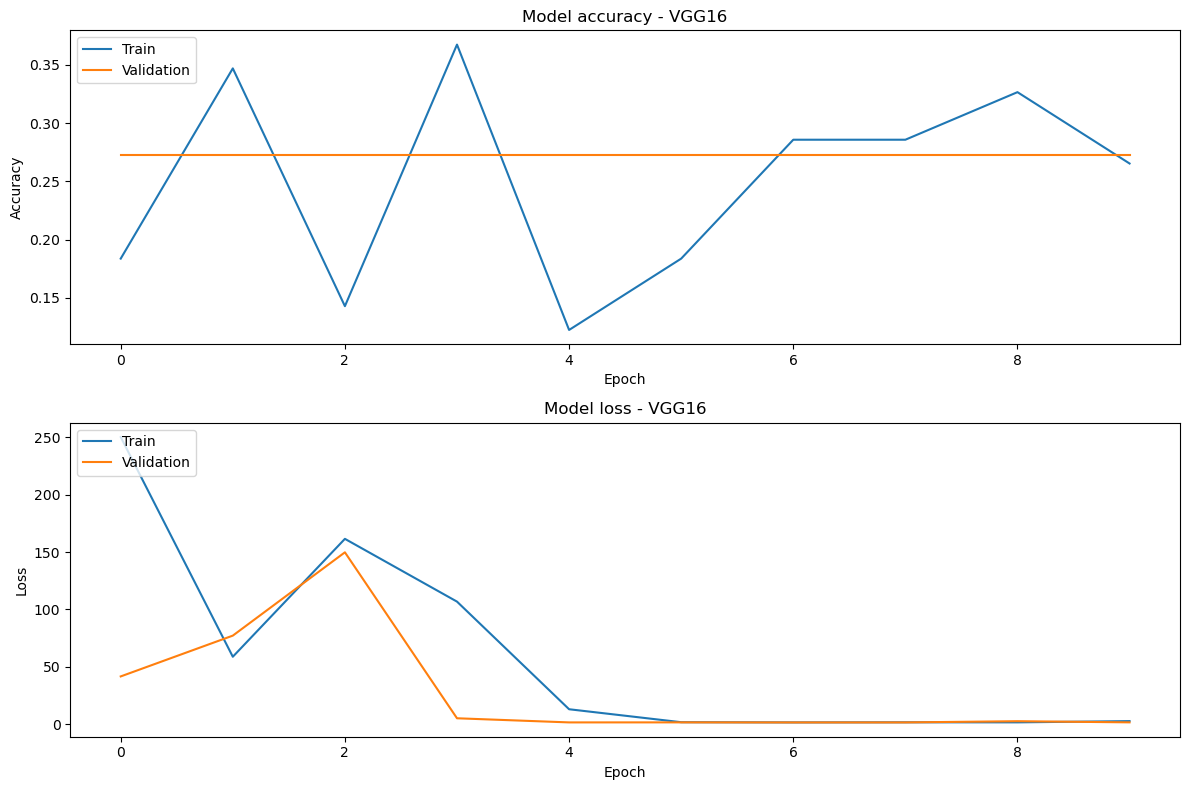

VGG16 model and history saved in directory: ./split_datav3


In [1]:
#debugging
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json

# Define a custom callback to print messages and store history
class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

# Define directories
save_dir = './split_datav3'
os.makedirs(save_dir, exist_ok=True)

# Load the split data
X_rp_train = np.load(os.path.join(save_dir, 'X_rp_train.npy'))
X_gaf_train = np.load(os.path.join(save_dir, 'X_gaf_train.npy'))
X_mtf_train = np.load(os.path.join(save_dir, 'X_mtf_train.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train.npy'))

X_rp_val = np.load(os.path.join(save_dir, 'X_rp_val.npy'))
X_gaf_val = np.load(os.path.join(save_dir, 'X_gaf_val.npy'))
X_mtf_val = np.load(os.path.join(save_dir, 'X_mtf_val.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val.npy'))

X_rp_test = np.load(os.path.join(save_dir, 'X_rp_test.npy'))
X_gaf_test = np.load(os.path.join(save_dir, 'X_gaf_test.npy'))
X_mtf_test = np.load(os.path.join(save_dir, 'X_mtf_test.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test.npy'))

# Resize images to (224, 224, 3) and keep only RGB channels
def resize_images(images):
    resized_images = []
    for img in images:
        img = tf.image.resize(img, [224, 224])
        img = img[:, :, :3]  # Keep only RGB channels
        resized_images.append(img)
    return np.array(resized_images)

X_rp_train = resize_images(X_rp_train)
X_gaf_train = resize_images(X_gaf_train)
X_mtf_train = resize_images(X_mtf_train)
X_rp_val = resize_images(X_rp_val)
X_gaf_val = resize_images(X_gaf_val)
X_mtf_val = resize_images(X_mtf_val)
X_rp_test = resize_images(X_rp_test)
X_gaf_test = resize_images(X_gaf_test)
X_mtf_test = resize_images(X_mtf_test)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Clone the base model for each input with unique names
    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Train VGG16 model
vgg16_history = vgg16_model.fit(
    [X_rp_train, X_gaf_train, X_mtf_train], y_train,
    epochs=10, batch_size=32, validation_data=([X_rp_val, X_gaf_val, X_mtf_val], y_val),
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate([X_rp_test, X_gaf_test, X_mtf_test], y_test)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")
